#**Speech Emotion Recognition**
## Neural Networks



## Dataset
### The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS) 


---

##### This portion of the RAVDESS contains 1440 files: 60 trials per actor x 24 actors = 1440. The RAVDESS contains 24 professional actors (12 female, 12 male), vocalizing two lexically-matched statements in a neutral North American accent. Speech emotions includes calm, happy, sad, angry, fearful, surprise, and disgust expressions. Each expression is produced at two levels of emotional intensity (normal, strong), with an additional neutral expression. So for convenience, here's the filename identifiers as per the official RAVDESS website:
* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 =  
* fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

---



# Install following libraries

In [1]:
!pip install librosa  
!pip install soundfile
!pip install pyaudio

  Using cached https://files.pythonhosted.org/packages/ab/42/b4f04721c5c5bfc196ce156b3c768998ef8c0ae3654ed29ea5020c749a6b/PyAudio-0.2.11.tar.gz
  ERROR: Failed building wheel for pyaudio
  Running setup.py clean for pyaudio
Failed to build pyaudio
    Running setup.py install for pyaudio ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-_mmdffee/pyaudio/setup.py'"'"'; __file__='"'"'/tmp/pip-install-_mmdffee/pyaudio/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-b990fetd/install-record.txt --single-version-externally-managed --compile Check the logs for full command output.


# Import libraries 

In [56]:
import librosa
import librosa.display
import soundfile
import os, glob, pickle
import numpy as np
import pandas as pd
import IPython.display as ipd 

from matplotlib.pyplot import specgram
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler

import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Input, Permute
from keras.utils import to_categorical
from keras.layers import Flatten, Dropout, Activation, BatchNormalization, Reshape, concatenate
from keras.layers import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, GlobalAveragePooling1D, LSTM, GlobalMaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

## Mount Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Features Extraction

Define a function extract_feature to extract the mfcc, chroma, and mel features from a sound file. This function takes 4 parameters- the file name and three Boolean parameters for the three features:

* mfcc: Mel Frequency Cepstral Coefficient, represents the short-term power spectrum of a sound
* chroma: Pertains to the 12 different pitch classes
* mel: Mel Spectrogram Frequency
* Contrast 
* Tonnetz (tonnetz)

In [4]:
def extract_feature(file_name, mfcc, chroma, mel, tonnetz, contrast):
        # Load librosa array
        X, sample_rate = librosa.load(os.path.join(file_name), res_type='kaiser_fast')
        # Obtain the following features
        if chroma or contrast:
            stft = np.abs(librosa.stft(X))
            result = np.array([])
        # Mel Frequency Cepstral Coefficient
        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result = np.hstack((result, mfccs))
        if chroma:
            chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result = np.hstack((result, chroma))
        # Mel Spectrogram Frequency
        if mel:
            mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result = np.hstack((result, mel))
        if contrast:
            contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
            result = np.hstack((result, contrast))
        if tonnetz:
            tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
            result = np.hstack((result, tonnetz))
        return result

Now, let’s define a dictionary to hold numbers and the emotions available in the RAVDESS, and a list to hold all emotions:
 1. Neutral
 2. Calm
 3. Happy
 4. Sad
 5. Angry
 6. Fearful
 7. Disgust
 8. Surprised 

In [5]:
# All Emotions in the RAVDESS dataset
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}
# Emotions to observe
observed_emotions=['neutral','calm','happy','sad','angry']

## Load the data and extract features for each sound file

In [8]:
def load_data(test_size=0.2):
    X,y=[],[]
    # Read speech files 
    for file in glob.glob('/content/drive/MyDrive/Data/Actor_*/*.wav'):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]
        # Only keep the observed emotion we set 
        if emotion not in observed_emotions:
            continue
       
         # Extract speech features
        feature=extract_feature(file, 
                                mfcc=True, 
                                chroma=False, 
                                mel=False, 
                                tonnetz=False, 
                                contrast=True)
        # Append all the fetures and target into X and y lists
        X.append(feature)
        y.append(emotion)
    # Return X_train, X_test, y_train, y_test
    return train_test_split(np.array(X), 
                            y, 
                            test_size = test_size,
                            random_state=42)

## Split the Dataset
Time to split the dataset into training and testing sets!

In [9]:
# Split the dataset
X_train, X_test, y_train, y_test = load_data(test_size=0.25)

###Observe the shape of the training and testing datasets:

In [10]:
# Shape of training data
print("[+] Shape of training samples:", X_train.shape)

# Shape of testing data
print("[+] Shape of testing samples:", X_test.shape)

[+] Shape of training samples: (648, 47)
[+] Shape of testing samples: (216, 47)


### Number of features extracted.

In [11]:
# Get the number of features extracted
print(f'Features extracted: {X_train.shape[1]}')

Features extracted: 47


# Prepare training and testing data for CNN

## Standarization

In [12]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

## One hot encoder

In [13]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# one hot encode the target 
lb = LabelEncoder()
y_train = keras.utils.to_categorical(lb.fit_transform(y_train))
y_test = keras.utils.to_categorical(lb.fit_transform(y_test))

print(X_train.shape)
print(lb.classes_)

# Pickel the lb object for future use 
filename = 'labels'
outfile = open(filename,'wb')
pickle.dump(lb,outfile)
outfile.close()

(648, 47)
['angry' 'calm' 'happy' 'neutral' 'sad']


In [14]:
X_train_dim = np.asarray(np.expand_dims(X_train, axis=2))
X_test_dim = np.asarray(np.expand_dims(X_test, axis=2))

In [15]:
# Shape of training data
print("[+] Shape of training samples:", X_train_dim.shape)
# Shape of testing data
print("[+] Shape of testing samples:", X_test_dim.shape)

[+] Shape of training samples: (648, 47, 1)
[+] Shape of testing samples: (216, 47, 1)


## Fully Connected Neural Network

In [16]:
model = Sequential()
model.add(Dense(100, input_shape=(47,1), activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(20, activation="relu"))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(5, activation="softmax"))

model.summary()
model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'], 
              optimizer='adam')

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 47, 100)           200       
_________________________________________________________________
dropout (Dropout)            (None, 47, 100)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 47, 50)            5050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 47, 50)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 47, 20)            1020      
_________________________________________________________________
dropout_2 (Dropout)          (None, 47, 20)            0         
_________________________________________________________________
flatten (Flatten)            (None, 940)               0

In [17]:
history = model.fit(X_train_dim,
                    np.asarray(y_train), 
                    batch_size=64, 
                    epochs = 100, 
                    validation_data=(X_test_dim, np.asarray(y_test)),
                    callbacks=[early_stop])

Epoch 1/100
11/11 [==============================] - 0s 35ms/step - loss: 1.6096 - accuracy: 0.2238 - val_loss: 1.5758 - val_accuracy: 0.2546
Epoch 2/100
11/11 [==============================] - 0s 15ms/step - loss: 1.5523 - accuracy: 0.2840 - val_loss: 1.5411 - val_accuracy: 0.3009
Epoch 3/100
11/11 [==============================] - 0s 16ms/step - loss: 1.5164 - accuracy: 0.3071 - val_loss: 1.4997 - val_accuracy: 0.3241
Epoch 4/100
11/11 [==============================] - 0s 17ms/step - loss: 1.4767 - accuracy: 0.3596 - val_loss: 1.4586 - val_accuracy: 0.3565
Epoch 5/100
11/11 [==============================] - 0s 16ms/step - loss: 1.4259 - accuracy: 0.3843 - val_loss: 1.4162 - val_accuracy: 0.4028
Epoch 6/100
11/11 [==============================] - 0s 16ms/step - loss: 1.3899 - accuracy: 0.4228 - val_loss: 1.3689 - val_accuracy: 0.4213
Epoch 7/100
11/11 [==============================] - 0s 15ms/step - loss: 1.3420 - accuracy: 0.4182 - val_loss: 1.3284 - val_accuracy: 0.4259
Epoch 

In [18]:
loss, accuracy = model.evaluate(X_train_dim, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_dim, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

y_pred=model.predict(X_test_dim, batch_size=200, verbose=1)
report = classification_report(y_test, y_pred.round())
print(report)

21/21 [==============================] - 0s 2ms/step - loss: 0.5972 - accuracy: 0.7978
Training Accuracy: 0.7978
Testing Accuracy:  0.6296
2/2 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.89      0.78      0.83        51
           1       0.61      0.50      0.55        46
           2       0.67      0.45      0.54        44
           3       0.44      0.15      0.23        26
           4       0.62      0.37      0.46        49

   micro avg       0.70      0.49      0.57       216
   macro avg       0.65      0.45      0.52       216
weighted avg       0.67      0.49      0.56       216
 samples avg       0.49      0.49      0.49       216



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


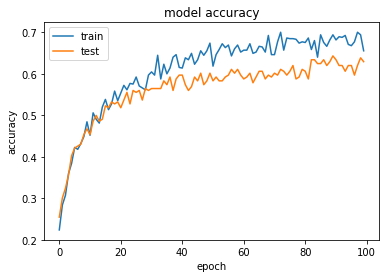

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

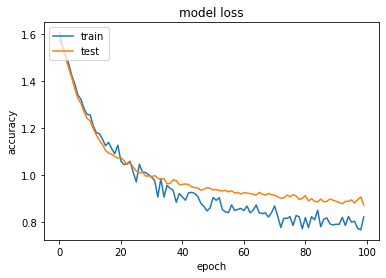

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# CNN

In [114]:
# New model
model = Sequential()
model.add(Conv1D(32, 5, padding='same', input_shape=(47,1)))  # X_train.shape[1] = No. of Columns))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(4)))
model.add(Conv1D(64, 5, padding='same', activation= 'relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(4)))
model.add(Conv1D(128, 5, padding='same', activation= 'relu'))
model.add(Dropout(0.1))
model.add(Dense(20, activation='relu')) 
model.add(Flatten())
model.add(Dense(5, activation='softmax')) # Target class number
model.summary()
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_51 (Conv1D)           (None, 47, 32)            192       
_________________________________________________________________
dropout_36 (Dropout)         (None, 47, 32)            0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 11, 32)            0         
_________________________________________________________________
conv1d_52 (Conv1D)           (None, 11, 64)            10304     
_________________________________________________________________
dropout_37 (Dropout)         (None, 11, 64)            0         
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 2, 64)             0         
_________________________________________________________________
conv1d_53 (Conv1D)           (None, 2, 128)          

In [115]:
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.RMSprop(lr=0.00005, rho=0.9, epsilon=1e-07, decay=0.0),
              metrics=['accuracy'])

# keras.optimizers.Adam(lr=0.0001)

In [116]:
history = model.fit(X_train_dim,
                    np.asarray(y_train), 
                    batch_size=16, 
                    epochs = 100, 
                    validation_data=(X_test_dim, np.asarray(y_test)))

Epoch 1/100
41/41 [==============================] - 0s 10ms/step - loss: 1.5970 - accuracy: 0.1960 - val_loss: 1.5871 - val_accuracy: 0.2454
Epoch 2/100
41/41 [==============================] - 0s 5ms/step - loss: 1.5809 - accuracy: 0.2608 - val_loss: 1.5757 - val_accuracy: 0.2454
Epoch 3/100
41/41 [==============================] - 0s 5ms/step - loss: 1.5665 - accuracy: 0.2762 - val_loss: 1.5648 - val_accuracy: 0.2454
Epoch 4/100
41/41 [==============================] - 0s 5ms/step - loss: 1.5558 - accuracy: 0.2670 - val_loss: 1.5543 - val_accuracy: 0.2546
Epoch 5/100
41/41 [==============================] - 0s 5ms/step - loss: 1.5453 - accuracy: 0.2809 - val_loss: 1.5449 - val_accuracy: 0.2593
Epoch 6/100
41/41 [==============================] - 0s 5ms/step - loss: 1.5367 - accuracy: 0.2963 - val_loss: 1.5356 - val_accuracy: 0.2593
Epoch 7/100
41/41 [==============================] - 0s 5ms/step - loss: 1.5271 - accuracy: 0.3071 - val_loss: 1.5268 - val_accuracy: 0.2731
Epoch 8/100


In [117]:
loss, accuracy = model.evaluate(X_train_dim, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_dim, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

y_pred=model.predict(X_test_dim, batch_size=200, verbose=1)
report = classification_report(y_test, y_pred.round())
print(report)

21/21 [==============================] - 0s 2ms/step - loss: 0.9942 - accuracy: 0.6343
Training Accuracy: 0.6343
Testing Accuracy:  0.5324
2/2 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.97      0.59      0.73        51
           1       0.59      0.22      0.32        46
           2       0.71      0.27      0.39        44
           3       0.00      0.00      0.00        26
           4       1.00      0.08      0.15        49

   micro avg       0.81      0.26      0.39       216
   macro avg       0.65      0.23      0.32       216
weighted avg       0.72      0.26      0.35       216
 samples avg       0.26      0.26      0.26       216



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


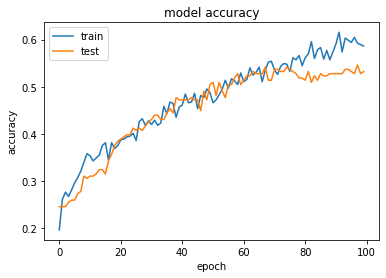

In [118]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

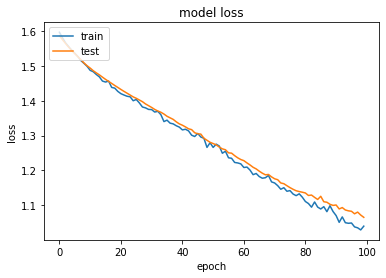

In [119]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Another CNN

In [107]:
CNN_model = Sequential()

CNN_model.add(Conv1D(16, 5,padding='same',input_shape=(47, 1), activation='relu'))
CNN_model.add(Conv1D(32, 5,padding='same',activation='relu'))
CNN_model.add(Dropout(0.6))
CNN_model.add(Flatten())
CNN_model.add(Dense(64, activation ='relu'))
CNN_model.add(Dropout(0.1))
CNN_model.add(Dense(32, activation ='relu'))
CNN_model.add(Dense(5, activation='softmax'))

In [108]:
CNN_model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_49 (Conv1D)           (None, 47, 16)            96        
_________________________________________________________________
conv1d_50 (Conv1D)           (None, 47, 32)            2592      
_________________________________________________________________
dropout_34 (Dropout)         (None, 47, 32)            0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 1504)              0         
_________________________________________________________________
dense_46 (Dense)             (None, 64)                96320     
_________________________________________________________________
dropout_35 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_47 (Dense)             (None, 32)              

In [109]:
CNN_model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.Adam(lr=0.0001),
                  metrics=['accuracy'])

In [110]:
history = CNN_model.fit(X_train_dim,
                        np.asarray(y_train), 
                        batch_size=16, 
                        epochs = 100, 
                        validation_data=(X_test_dim, np.asarray(y_test)))

Epoch 1/100
41/41 [==============================] - 0s 8ms/step - loss: 1.6190 - accuracy: 0.2392 - val_loss: 1.5751 - val_accuracy: 0.2546
Epoch 2/100
41/41 [==============================] - 0s 4ms/step - loss: 1.5646 - accuracy: 0.2654 - val_loss: 1.5422 - val_accuracy: 0.3889
Epoch 3/100
41/41 [==============================] - 0s 4ms/step - loss: 1.5318 - accuracy: 0.3349 - val_loss: 1.5120 - val_accuracy: 0.3935
Epoch 4/100
41/41 [==============================] - 0s 4ms/step - loss: 1.4906 - accuracy: 0.3627 - val_loss: 1.4783 - val_accuracy: 0.3704
Epoch 5/100
41/41 [==============================] - 0s 4ms/step - loss: 1.4627 - accuracy: 0.3549 - val_loss: 1.4432 - val_accuracy: 0.3981
Epoch 6/100
41/41 [==============================] - 0s 5ms/step - loss: 1.4337 - accuracy: 0.3966 - val_loss: 1.4098 - val_accuracy: 0.4213
Epoch 7/100
41/41 [==============================] - 0s 4ms/step - loss: 1.4087 - accuracy: 0.3889 - val_loss: 1.3817 - val_accuracy: 0.4120
Epoch 8/100
4

In [111]:
loss, accuracy = CNN_model.evaluate(X_train_dim, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = CNN_model.evaluate(X_test_dim, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

y_pred= CNN_model.predict(X_test_dim, batch_size=200, verbose=1)
report = classification_report(y_test, y_pred.round())
print(report)

21/21 [==============================] - 0s 2ms/step - loss: 0.3232 - accuracy: 0.9136
Training Accuracy: 0.9136
Testing Accuracy:  0.6620
2/2 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.89      0.82      0.86        51
           1       0.68      0.70      0.69        46
           2       0.70      0.70      0.70        44
           3       0.70      0.27      0.39        26
           4       0.71      0.41      0.52        49

   micro avg       0.75      0.61      0.67       216
   macro avg       0.74      0.58      0.63       216
weighted avg       0.75      0.61      0.66       216
 samples avg       0.61      0.61      0.61       216



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


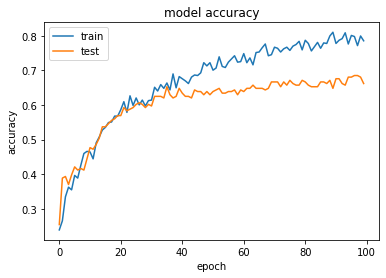

In [112]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

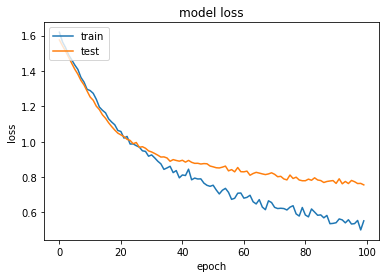

In [113]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# THE END